# Coffe Shop Purchase Analytics

Artificial model consists on analysis of approximatelly 1,000 transactions in coffe shop.

All data is faked. So the main purpose is to detect some strong correlations, visualize them and construct statistics-driven predictions.

Breaking in pieces, we're interested in such visualization params:

1) Aggregate frequency of each kind of drink/meal in all transactions
2) Classify most common meal+drink combinations

Prediction model is dedicatated to:

1) Determine the most popular meal+drink combination based on customers transactions

With aim of high accuracy, with obvious, fast and robust implementation Tensorflow+Keras framework are used in research.
However, even in fact that simple Bayesian probability may be used in that research, our goal is in introspecting neural network way of combination determination. It's assambled to concancantenate current model with other factor based models consuming much more params determing the transaction, so complexity regards in the future


In [2]:
import os.path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

For dataset it will be used kaggle opensourced csv file of hypotetical coffe shop. This code imports it via kagglehub open library and saves to cache directory

In [7]:
import kagglehub

path = kagglehub.dataset_download("sryasuka/coffee-shop-dataset")
filename = "coffee_shop_transactions.csv"

fullpath = os.path.join(path, filename)

print(fullpath)

/Users/shaya/.cache/kagglehub/datasets/sryasuka/coffee-shop-dataset/versions/1/coffee_shop_transactions.csv


Pandas library will be used to easily operate collected data values. Let's upload our csv file at first

In [8]:
import pandas as pd

df = pd.read_csv(fullpath)

print(df)

     TransactionID  Latte  Hazelnut Latte  Vanilla Latte  Creamy Aren Latte  \
0                1      0               0              1                  0   
1                2      0               0              0                  1   
2                3      0               0              0                  0   
3                4      1               0              0                  0   
4                5      0               0              1                  0   
..             ...    ...             ...            ...                ...   
995            996      0               0              1                  0   
996            997      0               0              0                  0   
997            998      0               0              1                  0   
998            999      0               0              0                  0   
999           1000      0               0              0                  0   

     Caramel Latte  Matcha Latte  Cappuccino  Caram

In current table transactionID is a primary key for a full purchase, so due to horizontal spreading of order details:
1) General amount of sold products may be calculated by vertically summarizing partitioned by each column, except for transactionID



In [9]:
column_sums = df.drop(columns=["TransactionID"]).sum()

print(column_sums)

Latte                     138
Hazelnut Latte            173
Vanilla Latte             149
Creamy Aren Latte         164
Caramel Latte             158
Matcha Latte              169
Cappuccino                167
Caramel Macchiato         173
Americano                 169
Matcha Bun                163
Cheese Toast              173
Chocolate Toast           172
Butter Toast              157
Cookies                   157
Croissant                 176
Egg Salad Toast           169
Fries                     175
Crispy Chicken Nuggets    161
dtype: int64


In matplotlib visualisation it looks like that:

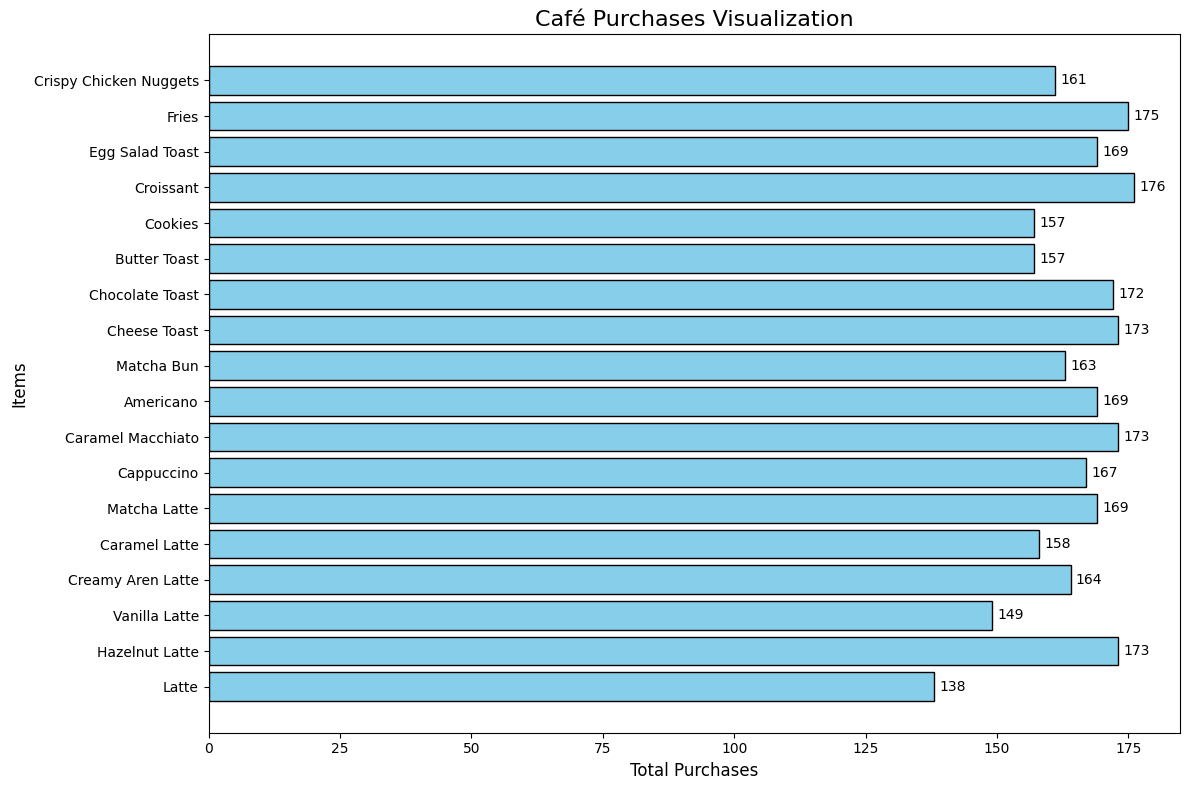

In [12]:
import matplotlib.pyplot as plt

items = list(column_sums.index)
values = column_sums.tolist()
# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(items, values, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Total Purchases", fontsize=12)
plt.ylabel("Items", fontsize=12)
plt.title("Café Purchases Visualization", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value annotations on bars
for index, value in enumerate(values):
    plt.text(value + 1, index, str(value), fontsize=10, va='center')

plt.tight_layout()
plt.show()


Second task is to classify the most popular meal & drink combination. It will be calculated as all combinations represented in orders book


In [13]:
df_bin = df.drop("TransactionID", axis=1)
df_bin = df_bin.apply(lambda x: x.astype(bool))

combinations = df_bin.groupby(list(df_bin.columns)).size().reset_index(name='Count')

print(combinations)

     Latte  Hazelnut Latte  Vanilla Latte  Creamy Aren Latte  Caramel Latte  \
0    False           False          False              False          False   
1    False           False          False              False          False   
2    False           False          False              False          False   
3    False           False          False              False          False   
4    False           False          False              False          False   
..     ...             ...            ...                ...            ...   
682   True            True          False              False           True   
683   True            True          False              False           True   
684   True            True          False               True          False   
685   True            True           True              False           True   
686   True            True           True               True          False   

     Matcha Latte  Cappuccino  Caramel Macchiato  A

Resulting amount is extremely wide, so the perfect way to previously get the most common combinations is to construct heats map. All data distributions will remain the same hence we could generate prioritization list by the descedenting grade of meals

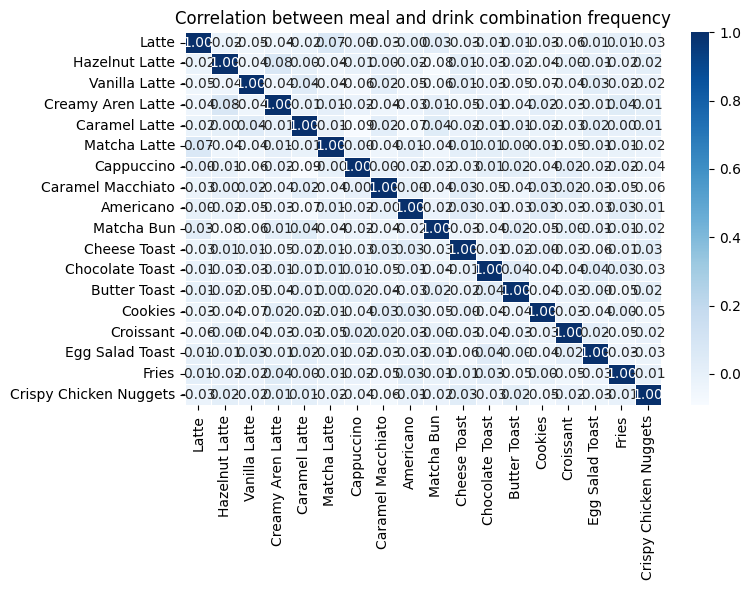

In [16]:
import seaborn as sns

corr_matrix = df_bin.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation between meal and drink combination frequency", fontsize=12)
plt.tight_layout()
plt.show()

The most comorbide combination is just one type of product, that gives 1.00 correlation equality. So almost zero and hundred percent must be ommited in any case except for quantile distibution like in our case.
Hence lets construct test model with softmax activation function in last layer. Linear crossentropy function will be used due to gradient scalling of combination frequency(check picture)

In [61]:
from sklearn.preprocessing import MinMaxScaler
from keras.src.optimizers import Adam, RMSprop
from keras.src.layers import Dropout

scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)
y = scaler.transform(df.values)

model = Sequential()

# layers
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(X.shape[1], activation='sigmoid'))

#optimizer and loss function
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

/Users/shaya/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Current plots present dynamic of training by accuracy and loss function values

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0411 - loss: 0.2535 - val_accuracy: 0.0750 - val_loss: 0.2284
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0810 - loss: 0.2210 - val_accuracy: 0.1000 - val_loss: 0.1857
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0789 - loss: 0.1770 - val_accuracy: 0.1650 - val_loss: 0.1464
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1015 - loss: 0.1474 - val_accuracy: 0.2500 - val_loss: 0.1381
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1528 - loss: 0.1432 - val_accuracy: 0.2550 - val_loss: 0.1321
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1898 - loss: 0.1316 - val_accuracy: 0.2750 - val_loss: 0.1243
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2172 - loss: 0.1278 - val_accuracy: 0.3100 - val_loss: 0.1161
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2706 - loss: 0.1237 - val_accuracy: 0.3400 - v

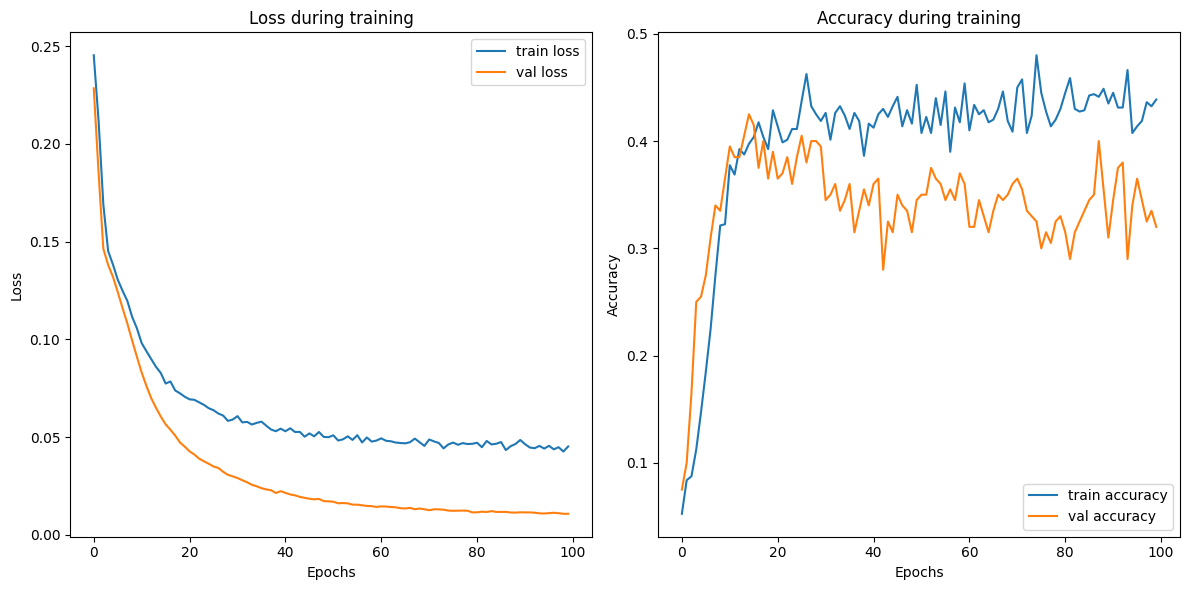

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# loss func graphic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy func graphic
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Now it's time to test our model in prediction of order

In [63]:
import numpy as np

new_order = np.array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]])  # order example
new_order = np.reshape(new_order, (1, X.shape[1]))

prediction = model.predict(new_order)

print("Predicted probabilities for each item in the order:")
for i, prob in enumerate(prediction[0]):
    print(f"{df.columns[i]}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted probabilities for each item in the order:
Latte: 0.25
Hazelnut Latte: 0.25
Vanilla Latte: 0.67
Creamy Aren Latte: 0.51
Caramel Latte: 0.35
Matcha Latte: 0.15
Cappuccino: 0.33
Caramel Macchiato: 0.05
Americano: 0.50
Matcha Bun: 0.03
Cheese Toast: 0.37
Chocolate Toast: 0.69
Butter Toast: 0.14
Cookies: 0.48
Croissant: 0.06
Egg Salad Toast: 0.69
Fries: 0.05
Crispy Chicken Nuggets: 0.02
